In [1]:
"""
A copy of the LinearRegressor class from linear_regressor module with added regularization
Note - regularization works fine with normal and batch GD,
    but it doesn't seem to give precise results with mini-batch of SGD

Also, and this is an issue that is true also when using scikit-learn,
    regularization doesn't seem to actually help remove unecessary high polynomials (see below) like suggested
    by scholars (e.g. Andrew Ng in his Couresera Machine Learning course)
"""

import numpy as np
import pandas as pd

class LinearRegressor(object):

    def __init__(self):
        self.coeff=None
    
    def fit(self,X,y,add_x0=True,method='normal',learning_rate=0.0001,epochs=100,starting_coeff=None,tolerance=
                         0.01, bin_size=10, regularization=0):
        """
        This is a simple linear regressor
        it uses the normal equation, batch gradient decent, or stochastic gradient decent to find the coeffcients
        it also automatically adds the first column x0 (all 1's) if it is missing

        output is given as a 1d array with the intercept as x0 and the coefficients as elements 1 through n

        if using batch gradient descent, a learning rate and number of ephochs can be provided
           these have no effect for normal equation
        also, starting coefficients can be provided
        when doing gradient decent, learning rate will gradually decrease if diverging
        if loss function improvement is smaller than tolance (in percentages) that learning rate will increase

        if using stochastic gradient descent, same as batch, but with bins instead of the whole set

        """
        # convert dataframe to ndarray
        if (type(X) is pd.DataFrame):
            X = X.values
        if (type(y) is pd.Series):
            y = y.values
        # if only using one feature:
        if (len(X.shape)==1):
            X.shape = (X.shape[0],1)
        # unless add_x0 is set to False, figure out whether a new column of 1's needs to be added
        if (add_x0) and (X[0,0]!=1 or len(np.unique(X[:,0]))>1):
            # n - number of samples, m - number of features (excluding the 1's)
            n,m = X.shape
            x0 = np.ones((n,1))
            x = np.hstack((x0,X))
            # update m
            m+=1
        else:
            n,m = X.shape
            x = X
        # perform regression, based on method
        if (method=='normal'):
            # normal equation
            self.coeff = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.transpose(),x)+regularization*np.identity(x.shape[1])),x.transpose()),y)
        else:
            # batch is same as mini-batch but the size is the total number of samples
            if (method=='batch'):
                bin_size = n
                
            if (starting_coeff is None):
                # initialize coefficients as 0's
                self.coeff = np.zeros(m)
            else:
                # use provided coefficients as a starting point
                self.coeff = np.asarray(starting_coeff)
            # start descent
            previous_error = float('inf')
            for epoch in range(epochs):
                # accumulating derivatives
                dc = np.zeros(m)
                error = 0 
                # +1 in case n is not a natural multiplication of bin_size
                for batch in (range(int(n/bin_size)+1)):
                    # run one batch
                    for j in range(bin_size):
                        # index of sample from entire dataset
                        i=batch*bin_size+j
                        # full iteration through dataset done
                        if (i>=n):
                            break
                        # x values
                        xs = x[i]
                        # label
                        y_real = y[i]
                        # prediction
                        h = np.dot(self.coeff,xs)
                        # derivation
                        dc+= (h-y_real)*xs
                        # error function (MSE)
                        error+= (h-y_real)**2
                    # update coefficients including regularization
                    self.coeff-= dc * (learning_rate/n) + (learning_rate/n)*regularization*self.coeff
                # end of batch/mini-batch loop
                # self correcting learning rate only for batch - in mini-batch MSE is not always going down on each iteration 
                if (method=='batch'):
                    # calculate total error and compare to previous error
                    if (error<previous_error):
                        # improvement
                        if (previous_error/error-1<tolerance):
                            # improvement is very small, increase learning rate
                            learning_rate *= 1.1
                    else:
                        # diverging
                        learning_rate/=2
                    previous_error = error
            # end of epochs loop

    def predict(self,X):
        """
        Predict and returns the values h for all samples provided
        """
        # convert dataframe to ndarray if needed
        if (type(X) is pd.DataFrame):
            X = X.values
        # add 1's as the first column if needed
        # here simply check if there is only one column missing
        if (X.shape[1]==self.coeff.shape[0]-1):
            n = X.shape[0]
            x0 = np.ones((n,1))
            X = np.hstack((x0,X))
        return np.squeeze(np.asarray(np.matmul(X,self.coeff)))


### Generate dataset

In [2]:
size = 500

coefficients = [6.2,-1.4,2.1,-3,11,-8]
x = np.ones((size,len(coefficients)))
for i in range(1,len(coefficients)):
    x[:,i]=np.random.rand(size)
y = (x*coefficients).sum(axis=1) + np.random.normal(size=size)

### Regression

In [3]:
reg = LinearRegressor()

** No regularization, coefficients are reproduced **

In [4]:
reg.fit(x,y,regularization=0)
reg.coeff

array([ 6.29606473, -1.3516777 ,  1.96500161, -2.96405227, 11.01830982,
       -8.09054707])

** With regularization, coefficients are slightly smaller **

In [5]:
reg.fit(x,y,regularization=10)
reg.coeff

array([ 5.06731864, -0.51353778,  1.95276201, -1.87329118,  9.47027686,
       -6.04770273])

In [6]:
reg.fit(x,y,method='batch',regularization=10)
reg.fit(x,y,method='batch',epochs=800, starting_coeff=reg.coeff,regularization=10)

reg.coeff

array([ 5.0661896 , -0.51130902,  1.95466903, -1.87127174,  9.47251826,
       -6.04551313])

** SGD results are over regularized **

In [7]:
reg.fit(x,y,method='batch',regularization=10)
reg.fit(x,y,method='stochastic',learning_rate=0.05,epochs=300,bin_size=10,starting_coeff=reg.coeff,regularization=10)
reg.fit(x,y,method='stochastic',learning_rate=0.02,epochs=1000,bin_size=10,starting_coeff=reg.coeff,regularization=10)
reg.fit(x,y,method='stochastic',learning_rate=0.001,epochs=1000,bin_size=10,starting_coeff=reg.coeff,regularization=10)

reg.coeff

array([ 4.53067009, -0.06134652,  1.86300852, -1.35950177,  8.35380181,
       -4.75373477])

### Testing usefulness against unecessary polynomials

** adding useless polynomials to dataset **

In [8]:
x_poly = np.hstack((x,(x[:,4]**3)[:,None],(x[:,4]**6)[:,None],(x[:,4]**9)[:,None]))

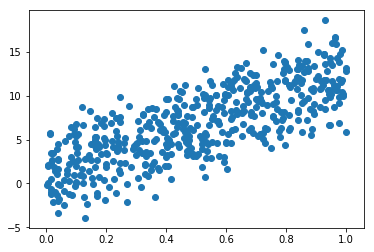

In [9]:
import matplotlib.pyplot as plt
plt.scatter(x[:,4],y)
plt.show()

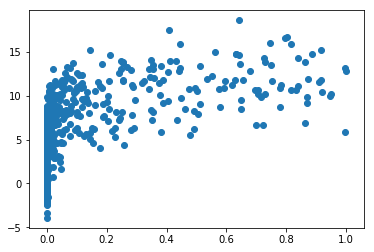

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x_poly[:,7],y)
plt.show()

In [11]:
reg.fit(x_poly,y,regularization=0)
reg.coeff

array([ 6.30641521, -1.33809594,  1.9808047 , -2.97445883, 11.21197255,
       -8.08996226, -2.10527625,  5.5063628 , -3.74753252])

Notice that the last free coefficients are not zero, even though they are unecessary high polynomials

In [12]:
reg.fit(x_poly,y,regularization=50)
reg.coeff

array([ 3.61117295,  0.55077973,  1.81421359, -0.34157498,  4.45931463,
       -2.74564751,  2.62152215,  1.32501485,  0.77808196])

Notice that the ^3 term still has a fairly high coefficient
<br>
Increasing the regularization further starts ruining the other coefficients
